# Importing Libraries and Data Loading

In [1]:
# Importing all the necessary libraries

import numpy as np
import os
import pandas as pd
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb
from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

import string
import itertools 
import re
import nltk
#nltk.download('stopwords')
#nltk.download('wordnet')
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk import word_tokenize, ngrams

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, Flatten, LSTM
from keras.layers import MaxPooling1D, Embedding
from keras.models import Model
from keras import backend as K
from keras.layers import GlobalMaxPooling1D, GlobalAveragePooling1D,GlobalMaxPool1D

E:\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Inserting training and test datasets
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# Some EDA and Data Preparation

In [3]:
train.head()

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",1
1,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1
2,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,1
3,z13lfzdo5vmdi1cm123te5uz2mqig1brz04,ferleck ferles,2013-11-27T21:39:24,Subscribe to my channel ﻿,1
4,z12avveb4xqiirsix04chxviiljryduwxg0,BeBe Burkey,2013-11-28T16:30:13,and u should.d check my channel and tell me wh...,1


In [4]:
# null values in train
train.isnull().sum(axis=0)

COMMENT_ID      0
AUTHOR          0
DATE          138
CONTENT         0
CLASS           0
dtype: int64

In [5]:
test.head()

,ID,COMMENT_ID,AUTHOR,DATE,CONTENT
0,0,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...
1,1,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com
2,2,LZQPQhLyRh9-wNRtlZDM90f1k0BrdVdJyN_YsaSwfxc,Jason Haddad,2013-11-26T02:55:11,"Hey, check out my new website!! This site is a..."
3,3,z122wfnzgt30fhubn04cdn3xfx2mxzngsl40k,Bob Kanowski,2013-11-28T12:33:27,i turned it on mute as soon is i came on i jus...
4,4,z13ttt1jcraqexk2o234ghbgzxymz1zzi04,Cony,2013-11-28T16:01:47,You should check my channel for Funny VIDEOS!!﻿


In [6]:
# null values in test
test.isnull().sum(axis=0)

ID              0
COMMENT_ID      0
AUTHOR          0
DATE          107
CONTENT         0
dtype: int64

In [7]:
# Unique values of Author
print('Unique values of Author in training : ', len(set(train['AUTHOR'].to_list())))
print('Unique values of Author in test : ', len(set(test['AUTHOR'].to_list())))

Unique values of Author in training :  1094
Unique values of Author in test :  760


# Notes :

1. DATE column has some missing values in both train and test dataset but this will not have impact on prediction
2. COMMENT_ID and DATE have no significance in prediction of CLASS so that should be removed
3. For significance of Author, we must check the number of unique values in both datasets, number of rows and number of unique values in Author are almost similar which means that there is one unique author for each comment, so the Author column plays no significance in classifcation and should also be removed


1    586
0    571
Name: CLASS, dtype: int64


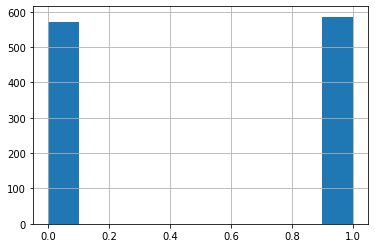

In [8]:
# Value count and histogram plot
print(train['CLASS'].value_counts())
train['CLASS'].hist()

The number of 0s and 1s are almost same in the training and test data which means that this is a balanced dataset

Only considering relevant features (CONTENT, CLASS for train and ID, CONTENT for test) for further analysis

In [9]:
train = train[["CONTENT", "CLASS"]]
test = test[["ID","CONTENT"]]

# Hypothesis

1. As per my industrial knowledge, I think the words like "like", "subscribe", "watch", "please" and the weblinks containing rows is more likely an Ad as these type of words are used in a sentence when someone wants you to visit, like or subscribe their website, page or channel,.

2. For this, we made a funtion which provides the number of occurence of a word, its value counts and a plot between class and frequency.

3. First, we are going to run the funtion for the "http" as these are the most common characters indicating a weblink.

4. After cleaning the text, we will be run the function to check my hypothesis.

In [10]:
#Function to calculate the occurence of the word, its value counts, comparison b/w class & frequency

def analysis(i):
    print( "\033[1m" + 'Analysis for: ' + str(i) + "\033[0m")
    print()
    print('Total Number of Occurence: ')
    # number of occurence of the word
    print(train.CONTENT.str.count(i).sum())
    print()
    print('Total Value Counts: ')
    # total value counts of the word
    print(train.CONTENT.str.count(i).value_counts())
    print()
    df_analys=pd.DataFrame()
    df_analys['freq']=train.CONTENT.str.count(i).to_list()
    df_analys['CLASS']=train['CLASS']
    df_analys['mark']= [j for j in range(0,train.shape[0])]
    print('Comparison Table: ')
    print()
    # comparison plot b/w class and frequency
    print(df_analys.pivot_table(index='CLASS',columns='freq',aggfunc='count', values = 'mark'))
    print()
    print("----------------------------------------------------------------------------------------")
    print()

In [11]:
# calling the above funtion for 'http'
analysis('http')

Analysis for: http

Total Number of Occurence: 
149

Total Value Counts: 
0    1031
1     111
2      12
7       1
4       1
3       1
Name: CONTENT, dtype: int64

Comparison Table: 

freq       0      1     2    3    4    7
CLASS                                   
0      561.0    8.0   2.0  NaN  NaN  NaN
1      470.0  103.0  10.0  1.0  1.0  1.0

----------------------------------------------------------------------------------------



# Note 

1. In the above output, "http" has significance occurence and from the plot, it can be state that whemever "http" occurs, it is more likely to be an ad.
Also, the more its occurence, the more chances of it being an ad.
2. While cleaning the text, we will not remove the words containing "http", but it has to be replaced with something which can distinguish it and add value while training.
3. Replacing the urls with "replacedlink"

In [12]:
# function to clean data

stop_words = set(stopwords.words('english'))

def cleanData(text, lowercase = False, remove_stops = False, stemming = False, lemmatization = False):
    txt = str(text)
    
    # Replace apostrophes with standard lexicons
    txt = txt.replace("isn't", "is not")
    txt = txt.replace("aren't", "are not")
    txt = txt.replace("ain't", "am not")
    txt = txt.replace("won't", "will not")
    txt = txt.replace("didn't", "did not")
    txt = txt.replace("shan't", "shall not")
    txt = txt.replace("haven't", "have not")
    txt = txt.replace("hadn't", "had not")
    txt = txt.replace("hasn't", "has not")
    txt = txt.replace("don't", "do not")
    txt = txt.replace("wasn't", "was not")
    txt = txt.replace("weren't", "were not")
    txt = txt.replace("doesn't", "does not")
    txt = txt.replace("'s", " is")
    txt = txt.replace("'re", " are")
    txt = txt.replace("'m", " am")
    txt = txt.replace("'d", " would")
    txt = txt.replace("'ll", " will")
    txt = txt.replace("--th", " ")
    
    # More cleaning
    txt = re.sub(r"alot", "a lot", txt)
    txt = re.sub(r"what's", "", txt)
    txt = re.sub(r"What's", "", txt)
    
    
    # Removing URLs
    #print('before', txt)
    txt= re.sub(r"\S*http\S*", "replacedlink", txt)
    txt= re.sub(r"\S*.com\S*", "replacedlink", txt)
    
    # Removing all symbols
    txt = re.sub(r'[^A-Za-z\s]',r' ',txt)
    txt = re.sub(r'\n',r' ',txt)
    #print('after', txt)
    
    # convert to lowercase
    if lowercase:
        txt = " ".join([w.lower() for w in txt.split()])
        
    # removing stop words (a, an, the...)   
    if remove_stops:
        txt = " ".join([w for w in txt.split() if w not in stop_words])
       
    # Stemming (remove -ing, -ly, ...)
    if stemming:
        st = PorterStemmer()
        txt = " ".join([st.stem(w) for w in txt.split()])
        
    # Lemmatisation (convert the word into root word)
    if lemmatization:
        wordnet_lemmatizer = WordNetLemmatizer()
        txt = " ".join([wordnet_lemmatizer.lemmatize(w, pos='v') for w in txt.split()])

    return txt

In [13]:
# calling the clean function for train and test
# Lemmatication is performing better than stemming so considering that
train['CONTENT'] = train['CONTENT'].map(lambda x: cleanData(x, lowercase=True, remove_stops=True, stemming=False, lemmatization = True))
test['CONTENT'] = test['CONTENT'].map(lambda x: cleanData(x, lowercase=True, remove_stops=True, stemming=False, lemmatization = True))

In [14]:
# calling the analysis function for different words
lis=['replacedlink', 'subscribe', 'like', 'watch','please', 'share']
df1=pd.DataFrame()
df1['name']=lis
df1['name'].apply(analysis)

Analysis for: replacedlink

Total Number of Occurence: 
278

Total Value Counts: 
0    931
1    191
2     24
3      8
4      2
7      1
Name: CONTENT, dtype: int64

Comparison Table: 

freq       0      1     2    3    4    7
CLASS                                   
0      540.0   29.0   2.0  NaN  NaN  NaN
1      391.0  162.0  22.0  8.0  2.0  1.0

----------------------------------------------------------------------------------------

Analysis for: subscribe

Total Number of Occurence: 
161

Total Value Counts: 
0    1014
1     126
2      16
3       1
Name: CONTENT, dtype: int64

Comparison Table: 

freq       0      1     2    3
CLASS                         
0      571.0    NaN   NaN  NaN
1      443.0  126.0  16.0  1.0

----------------------------------------------------------------------------------------

Analysis for: like

Total Number of Occurence: 
152

Total Value Counts: 
0    1029
1     108
2      17
3       2
4       1
Name: CONTENT, dtype: int64

Comparison Table: 

freq

0    None
1    None
2    None
3    None
4    None
5    None
Name: name, dtype: object

# Observations

1. The occurence of 'replacedlink' roughly translates to 85% chance of being an ad which makes sense as the ad usually has a weblink asking the user to visit it. Not removing URLs was a good decision
2. If 'subscribe' occurs, it is always an ad.
3. Despite having lesser occurence, 'please' and 'share' have more than 90% chance of being ad if they occur.
4. My hypothesis is correct and sentences containing these words are more likely to be an ad

In [15]:
# Creating Bag of Words Vector
#CountVec = CountVectorizer(max_features = 5000, ngram_range=(1,1))
#Countvec_train = CountVec.fit_transform(train['CONTENT']).toarray()
#Countvec_test = CountVec.transform(test['CONTENT']).toarray()
#print(Countvec_train .shape, Countvec_test.shape)

In [16]:
# Creating Tf-idf vector
# For the final, tf-idf is used as it was perfomring better
tf = TfidfVectorizer(max_features = 5000, ngram_range=(1,1))
tfidf_train = tf.fit_transform(train['CONTENT']).toarray()
tfidf_test = tf.transform(test['CONTENT']).toarray()
print(tfidf_train.shape, tfidf_test.shape)

(1157, 2254) (799, 2254)


# Train-validation split
# Model Creation

In [17]:
# First training the data on 66% of actual training data for validation
# Since the test size is not so different from training data, for final model, we will be using the whole data

In [18]:
# Splitting the dataset for validation
x = tfidf_train
y = train['CLASS']
trainx, testx, trainy, testy = train_test_split(x, y, test_size=0.33, random_state=42)

In [19]:
# Naive Bayes
nb_model = MultinomialNB().fit(trainx,trainy)
nb_output = nb_model.predict(testx)
print(roc_auc_score(testy, nb_output))

0.8844634628044766


In [20]:
# XGB 
xgb_model = xgb.XGBClassifier(objective='binary:logistic')
xgb_model.fit(trainx,trainy)
xgb_output = xgb_model.predict(testx)
print(roc_auc_score(testy, xgb_output))

0.934990125082291


In [21]:
# Random forest classifier - optimised
rf_model = RandomForestClassifier(random_state= 42,n_estimators=500, criterion = "entropy")
rf_model.fit(trainx,trainy)
rf_output = rf_model.predict(testx)
print(roc_auc_score(testy, rf_output))

0.9427803379416283


# Model created using all the training data, because of comparable train-test data

The model and hyperparameters which we are using here are the one we created during Train-Validation Split Model

In [25]:
# Random forest classifier on whole data - optimised 
rf_model = RandomForestClassifier(random_state= 42,n_estimators=500, criterion = "entropy")
rf_model.fit(tfidf_train,train['CLASS'])
rf_output = rf_model.predict(tfidf_test)

In [26]:
# writing the predicted values in csv file
# this is final output for the optimised machine learning algorithm
final_prediction = pd.DataFrame(test['ID'].copy())
final_prediction['CLASS']= rf_output
final_prediction.to_csv("Adarsh_Singh_15_classification.csv", index = False)

# Using Tokenizer and word embeddings to make the vectors

In [36]:
# Word Embeddings and use of neural networks gives better reuslt as it includes the semantic meaning
# we will use lstm to take advantage of its retaining power

In [28]:
# Tokenizer and Padding 
MAX_SEQUENCE_LENGTH = 100
MAX_NB_WORDS = 3000

tokenizer = Tokenizer(lower=False,num_words = MAX_NB_WORDS)
tokenizer.fit_on_texts(train['CONTENT'])

sequences = tokenizer.texts_to_sequences(train['CONTENT'])
test_sequences = tokenizer.texts_to_sequences(test['CONTENT'])

train_data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

print('Shape of train data tensor:', train_data.shape)


test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of test data tensor:', test_data.shape)


nb_words = (np.max(train_data) + 1)
print(nb_words)

Shape of train data tensor: (1157, 100)
Shape of test data tensor: (799, 100)
2272


In [29]:
# Word Embedding Vector
from keras.layers.recurrent import LSTM
model = Sequential()
model.add(Embedding(nb_words,50,input_length=MAX_SEQUENCE_LENGTH))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(loss= 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           113600    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 174,101
Trainable params: 174,101
Non-trainable params: 0
_________________________________________________________________


In [30]:
# Splitting embeddings data into train and validation
X = train_data
Y = train['CLASS']
trainx, testx, trainy, testy = train_test_split(X, Y, test_size=0.33, random_state=42)

In [31]:
# neural network on validation dataset
model.fit(trainx, trainy, validation_split=0.2, nb_epoch=10, batch_size=5)
result = model.predict(testx)
print(roc_auc_score(testy,result))

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  
E:\Anaconda\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 620 samples, validate on 155 samples
Epoch 1/10
620/620 [==============================] - 12s 19ms/step - loss: 0.5801 - accuracy: 0.7548 - val_loss: 0.3220 - val_accuracy: 0.9161
Epoch 2/10
620/620 [==============================] - 11s 18ms/step - loss: 0.2103 - accuracy: 0.9210 - val_loss: 0.1512 - val_accuracy: 0.9484
Epoch 3/10
620/620 [==============================] - 15s 24ms/step - loss: 0.0982 - accuracy: 0.9677 - val_loss: 0.1424 - val_accuracy: 0.9484
Epoch 4/10
620/620 [==============================] - 18s 30ms/step - loss: 0.0602 - accuracy: 0.9806 - val_loss: 0.1661 - val_accuracy: 0.9419
Epoch 5/10
620/620 [==============================] - 12s 19ms/step - loss: 0.0527 - accuracy: 0.9823 - val_loss: 0.2130 - val_accuracy: 0.9290
Epoch 6/10
620/620 [==============================] - 14s 23ms/step - loss: 0.0363 - accuracy: 0.9871 - val_loss: 0.1830 - val_accuracy: 0.9355
Epoch 7/10
620/620 [==============================] - 10s 16ms/step - loss: 0.0234 - accur

In [32]:
# running neural network with validation parameters on whole data
model.fit(train_data, train['CLASS'], validation_split=0.2, nb_epoch=10, batch_size=5)
result_nn = model.predict(test_data)
# converting the probabilites scores into 0 or 1
result_nn = [1 if i>0.5 else 0 for i in result_nn] 

Train on 925 samples, validate on 232 samples
Epoch 1/10
 10/925 [..............................] - ETA: 14s - loss: 0.0088 - accuracy: 1.0000

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


925/925 [==============================] - 14s 15ms/step - loss: 0.1251 - accuracy: 0.9611 - val_loss: 0.0787 - val_accuracy: 0.9741
Epoch 2/10
925/925 [==============================] - 14s 15ms/step - loss: 0.0350 - accuracy: 0.9892 - val_loss: 0.0893 - val_accuracy: 0.9741
Epoch 3/10
925/925 [==============================] - 14s 15ms/step - loss: 0.0159 - accuracy: 0.9978 - val_loss: 0.0948 - val_accuracy: 0.9698
Epoch 4/10
925/925 [==============================] - 14s 15ms/step - loss: 0.0105 - accuracy: 0.9989 - val_loss: 0.1247 - val_accuracy: 0.9698
Epoch 5/10
925/925 [==============================] - 15s 16ms/step - loss: 0.0200 - accuracy: 0.9924 - val_loss: 0.0893 - val_accuracy: 0.9784
Epoch 6/10
925/925 [==============================] - 14s 15ms/step - loss: 0.0278 - accuracy: 0.9914 - val_loss: 0.1084 - val_accuracy: 0.9741
Epoch 7/10
925/925 [==============================] - 14s 15ms/step - loss: 0.0089 - accuracy: 0.9989 - val_loss: 0.1213 - val_accuracy: 0.9741
Epo

In [33]:
# output csv for neural network
# this is the finla output for neural network using lstm
final_prediction_nn = pd.DataFrame(test['ID'].copy())
final_prediction_nn['CLASS']= result_nn
final_prediction_nn.to_csv("Adarsh_Singh_16_classification.csv", index = False)